# Нейросети в обработке текста

Нейросети могут выделить сложные паттерны — взаимоотношения в данных. Для текстов, паттерны проявляются, как именно слова употребляются вместе, как построены фразы. Другими словами, нейросети нужны для того, чтобы представить контекст в виде математического объекта — вектора или матрицы. 

### Основные блоки

1. **Свёрточные блоки** 
  * Для текстов используются одномерные свёртки.
  * Хорошо подходят для нахождения в данных локальных паттернов.
  * Эффективно распараллеливаются на видеокартах 
  * Достаточно быстрые и простые 
  * Хорошо учатся 
  * Недостаточно гибкие и мощные, для широких паттернов — например, сравнивать первое слово в предложении и последнее, игнорируя при этом слова между ними. А также, чтобы увеличить максимальную длину паттерна, нужно существенно увеличить количество параметров свёрточной сети.

2. **Рекуррентные блоки**
  * Последовательно токен за токеном
  * Информация обо всём предложении
  * В результате могут учитываться достаточно длинные зависимости. 
  * Учить гораздо сложнее.

3. **Блоки пулинга**
  * убирает мелкие детали и оставляет только значимые. 
  * соседние элементы матриц усредняются или заменяются на один — например, максимальный.

4. **Блоки внимания**
  * По сути, механизм внимания осуществляет попарное сравнение элементов двух последовательностей, и позволяет выбрать только наиболее значимые их элементы, чтобы продолжить работу только с ними, а всё остальное убрать. 
  * Сети "с вниманием", как правило, хорошо учатся. 

### Общее описание сверток


Работают они примерно так:  
<img src='https://drive.google.com/uc?export=view&id=1edbW-Y4y61tSaPIfN7YGGx5eHCxc4p1o'>

From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$

Но нужно не забывать, что свертки обычно имеют ещё такую размерность, как число каналов. Например, картинки имеют обычно три канала: RGB.  
Наглядно демонстрируется как выглядят при этом фильтры [здесь](http://cs231n.github.io/convolutional-networks/#conv).

После сверток обычно следуют pooling-слои. Они помогают уменьшить размерность тензора, с которым приходится работать. Самым частым является max-pooling:  

<img src='https://drive.google.com/uc?export=view&id=10TwIuQzfB52xBRkEhDSoIRctsXpyytoX'>

From [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/#pool)

### Свёртки для текстов

Каноничный пример одномерной свертки:

<img src='https://drive.google.com/uc?export=view&id=1H_G0v7H_bzpAXcWNV1b6rsSwnOFX1XDy'>


Как использовать **одномерную свертку при работе с текстами**:

(Текст закодирован через частотное кодирование)

<img src='https://drive.google.com/uc?export=view&id=1DzYTxl4eiNWHUMskM-MUjvbKrTbArqV1'>

Затем окно свертки сдвигается на один элемент вправо и всё повторяется по новой.



In [1]:
import torch

conv_1 = torch.nn.Conv1d( 1, 1, kernel_size=5, bias=False)
conv_1.weight = torch.nn.Parameter(torch.FloatTensor([[[0.2, 0.2, 0.2, 0.2, 0.2]]]))

conv_1.weight, conv_1.bias

(Parameter containing:
 tensor([[[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]]], requires_grad=True),
 None)

In [2]:
tens = torch.FloatTensor([[93, 1655, 16, 288, 4, 163]])
conv_1(tens[None])

tensor([[[411.2000, 425.2000]]], grad_fn=<ConvolutionBackward0>)

In [3]:
tens.shape

torch.Size([1, 6])

Чуть сложнее, когда слова представлены не через частотное кодирование, а через **эмбеддинги** (векторное представление):

Возьмем эмбеддинг размерности два для примера. 

В этом случае окно свертки остается таким же - равным 5, а вот размерность ядра свертки увеличивается: по одной размерности сохраняется размер окна, а по второй размерности элементов становится столько, сколько элементов в размерности эмбеддинга, то есть два.

<img src='https://drive.google.com/uc?id=1iuu_oMkSVlM93msmB3RcUv1_u8B2_qT3'>

In [4]:
import torch

conv_1 = torch.nn.Conv1d(1, 2, kernel_size=5, bias=False)
conv_1.weight = torch.nn.Parameter(torch.FloatTensor([[
                                    [0.1, 0.1, 0.1, 0.1, 0.1],
                                    [0.1, 0.1, 0.1, 0.1, 0.1]
]]))

conv_1.weight, conv_1.bias

(Parameter containing:
 tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000, 0.1000]]], requires_grad=True),
 None)

In [5]:
tens = torch.FloatTensor([[0.13, -0.11], [0.24, -0.19], [-0.01, -0.05], [0.07, -0.01], [0.01, 0.01]]).permute(1, 0)
conv_1(tens)
# bs, w, h

tensor([[0.0090]], grad_fn=<SqueezeBackward1>)

In [6]:
tens.shape

torch.Size([2, 5])

Эмбединг:

In [7]:
tens = torch.randint( 0,200,(2,10))
print(tens)
emb_1 = torch.nn.Embedding(200, 16)

x = emb_1(tens)
x.shape

tensor([[ 41,  52,  85, 132,  96,  34, 132,  16,   6, 110],
        [ 47,  61,   3,  88,   6,  58,  18, 176,  96,  77]])


torch.Size([2, 10, 16])

И еще при работе с одномерной сверткой могу использоваться слои подвыборки, как и в CNN для картинок, чаще используется операция взятия максимума из двух элементов.

<img src='https://drive.google.com/uc?export=view&id=1TKx1C-Tk1yN5xMBDQ1L_iLbRg5Rgjwan'>

В сетях таких блоков может быть несколько.


**Как теперь подбирать значения в ядре свертки?**

Для картинок мы могли вручную подобрать значения для нахожения границ объектов, для размытия, для увеличения четкости и т.д.

Для текстов так не получится, как собственно и не получается подобрать вручную фильтры для более сложных операций с картинками.



## Задача (Sentiment Analysis)

Собраны твиты 2-ух тональностей, необходимо произвести классификацию на 2-а класса.

In [8]:
max_words = 2000
max_len = 20
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

Ссылка на google drive: https://docs.google.com/spreadsheets/d/1yBeCq1mw9BHMdmxMlPEIUI0S235Q-evm/edit?usp=sharing&ouid=109954320369852068736&rtpof=true&sd=true

In [9]:
# from google.colab import drive
# drive.mount('/gdrive')


In [10]:
#path = '/gdrive/MyDrive/geekbrain/PyTorch/web6/'
path = ''

In [11]:
import pandas as pd

df_train = pd.read_csv(path+"data/train.csv")
df_val = pd.read_csv(path+"data/val.csv")

In [12]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


0 - negative<br>
1 - positive

In [13]:
df_train['class'].value_counts()

1    92063
0    89404
Name: class, dtype: int64

In [14]:
df_val.tail()

,id,text,class
22678,204145,А я знаю из-за кого такая паршивая погода была...,1
22679,204146,ааа.... что с Гмейлом. не ужто он умер сегодня...,0
22680,204147,"в учебники химии написано ""Пруст Жозеф Луи""\nя...",1
22681,204148,"Вот все любят,а я не люблю..как дура..говорю,ч...",0
22682,204149,уххх спасибо дорогой Леле Евгеньевне и Штепуху...,1


In [15]:
df_val['class'].value_counts()

1    11449
0    11234
Name: class, dtype: int64

### Предобработка

In [16]:
!pip install stop-words pymorphy2


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [17]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [18]:
sw = set(get_stop_words("ru"))
# sw

In [19]:
sw

{'а',
 'алло',
 'без',
 'близко',
 'более',
 'больше',
 'будем',
 'будет',
 'будете',
 'будешь',
 'будто',
 'буду',
 'будут',
 'будь',
 'бы',
 'бывает',
 'бывь',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'важная',
 'важное',
 'важные',
 'важный',
 'вам',
 'вами',
 'вас',
 'ваш',
 'ваша',
 'ваше',
 'ваши',
 'вверх',
 'вдали',
 'вдруг',
 'ведь',
 'везде',
 'весь',
 'вниз',
 'внизу',
 'во',
 'вокруг',
 'вон',
 'восемнадцатый',
 'восемнадцать',
 'восемь',
 'восьмой',
 'вот',
 'впрочем',
 'времени',
 'время',
 'все',
 'всегда',
 'всего',
 'всем',
 'всеми',
 'всему',
 'всех',
 'всею',
 'всю',
 'всюду',
 'вся',
 'всё',
 'второй',
 'вы',
 'г',
 'где',
 'говорил',
 'говорит',
 'год',
 'года',
 'году',
 'да',
 'давно',
 'даже',
 'далеко',
 'дальше',
 'даром',
 'два',
 'двадцатый',
 'двадцать',
 'две',
 'двенадцатый',
 'двенадцать',
 'двух',
 'девятнадцатый',
 'девятнадцать',
 'девятый',
 'девять',
 'действительно',
 'дел',
 'день',
 'десятый',
 'десять',
 'для',
 'до',
 'довольно',
 'до

In [20]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

**ПОЗАВТРАКАЛИ**

Стемминг (убираем лишнии куски слова):
**завтрак**<br>
Очень быстро, очень дешево и очень слабо.

Лемматизация (перевод в неопределенную форму для гл. и в им.падеж для сущ.):
**позавтракать**<br>
Небыстро, сложно.

In [21]:
morpher = MorphAnalyzer()
morpher.parse('завтракаем')[0].normal_form

'завтракать'

In [22]:
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [23]:
df_train['text'].iloc[:1].values

array(['@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.'],
      dtype=object)

In [24]:
df_train['text'].iloc[:1].apply(preprocess_text).values

array(['alisachachka неуезжаааааааать ❤ нехотеть уезжать'], dtype=object)

In [25]:
from tqdm import tqdm 
tqdm.pandas()

df_train['text'] = df_train['text'].progress_apply(preprocess_text)
df_val['text'] = df_val['text'].progress_apply(preprocess_text)

100%|███████████████████████████████████| 22683/22683 [00:11<00:00, 1957.52it/s]


In [26]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [27]:
!pip install nltk


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [28]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /home/mariya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['alisachachka', 'неуезжаааааааать', '❤', 'нехотеть', 'уезжать']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [29]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [30]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [31]:
tokens_filtered_top[:10]

['rt',
 'd',
 'хотеть',
 'новый',
 'завтра',
 'мой',
 'вообще',
 'хороший',
 'любить',
 'немочь']

In [32]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'rt': 1,
 'd': 2,
 'хотеть': 3,
 'новый': 4,
 'завтра': 5,
 'мой': 6,
 'вообще': 7,
 'хороший': 8,
 'любить': 9,
 'немочь': 10,
 'день': 11,
 'делать': 12,
 'смотреть': 13,
 'блин': 14,
 'самый': 15,
 'знать': 16,
 'идти': 17,
 'думать': 18,
 'дом': 19,
 '3': 20,
 'сидеть': 21,
 'небыть': 22,
 'друг': 23,
 'спать': 24,
 'утро': 25,
 'незнать': 26,
 'один': 27,
 'школа': 28,
 '2': 29,
 'сделать': 30,
 'настроение': 31,
 'такой': 32,
 'человек': 33,
 'пойти': 34,
 'писать': 35,
 'ждать': 36,
 'час': 37,
 'мама': 38,
 'нехотеть': 39,
 'любимый': 40,
 'работа': 41,
 'болеть': 42,
 'последний': 43,
 'написать': 44,
 'никто': 45,
 'ночь': 46,
 'свой': 47,
 'посмотреть': 48,
 'добрый': 49,
 'говорить': 50,
 'чтоть': 51,
 'неделя': 52,
 'какой': 53,
 'прийти': 54,
 'купить': 55,
 'вчера': 56,
 'мочь': 57,
 'дело': 58,
 'скучать': 59,
 'найти': 60,
 'скоро': 61,
 'хотеться': 62,
 'урок': 63,
 'фильм': 64,
 'снег': 65,
 'первый': 66,
 'голова': 67,
 'остаться': 68,
 'оо': 69,
 'жить': 70,
 'вид

In [33]:
import numpy as np


def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [34]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["text"]])

CPU times: user 10.1 s, sys: 31.9 ms, total: 10.1 s
Wall time: 10.1 s


In [35]:
x_train.shape

(181467, 20)

In [36]:
df_train['text'].iloc[1]

'rt galyginvadim ребята девчата кино любовь завтра вотэтолюбовь'

In [37]:
x_train[1]

array([  1, 196, 429, 161,   5,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [39]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [40]:
train_dataset = DataWrapper(x_train, df_train['class'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['class'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [41]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 20])
torch.Size([512])
tensor(1)


In [42]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01 )
criterion = nn.BCELoss()

In [45]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

/home/mariya/PycharmProjects/base/venv/lib/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/5]. Step [355/355]. Loss: 0.584. Acc: 0.685. Test loss: 0.809. Test acc: 0.707
Epoch [2/5]. Step [355/355]. Loss: 0.520. Acc: 0.720. Test loss: 0.798. Test acc: 0.711
Epoch [3/5]. Step [355/355]. Loss: 0.593. Acc: 0.731. Test loss: 0.545. Test acc: 0.709
Epoch [4/5]. Step [355/355]. Loss: 0.527. Acc: 0.742. Test loss: 0.377. Test acc: 0.712
Epoch [5/5]. Step [355/355]. Loss: 0.414. Acc: 0.754. Test loss: 0.075. Test acc: 0.713
Training is finished!


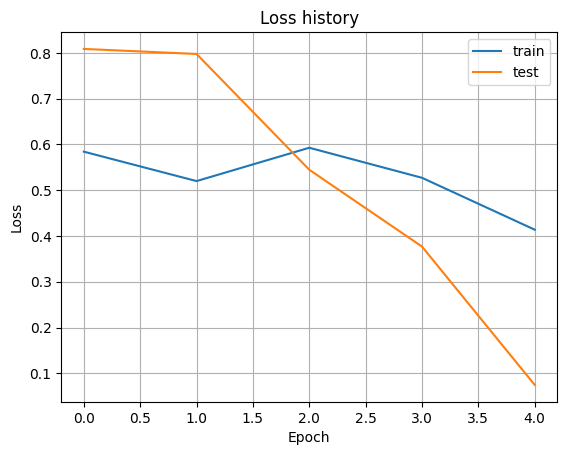

In [46]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

In [47]:
test_outputs.shape

torch.Size([3, 1])

In [48]:
test_outputs, test_labels

(tensor([[0.9192],
         [0.0175],
         [0.8854]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([1, 0, 1], device='cuda:0'))

## Домашнее задание
1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://drive.google.com/file/d/1S0hslcWDrwxA5GH4U32mfg85lAVLqkq5/view?usp=sharing

Вопросы:

А. Что такое токен:

  1. слово из текста
  2. индекс слова из текста по словарю
  3. номер слова в тексте

В. Зачем делать лематизации:

  1. для сниженя числа оригинальных слов словаря
  2. для снижения числа слов в предложении
  3. для уменьшения модели

С. Что сложнее стеминг или лематизация:

  1. стеминг
  2. лематизация

D. Сколько весов в слое torch.nn.Conv1d(10, 2, kernel_size=5, bias=False):

  1. 25
  2. 5
  3. 50
  4. 60

Е. Какой размерностью обладает тензор на выходе слоя torch.nn.Conv1d(1, 2, kernel_size=5, bias=False):

  1. 1
  2. 2
  3. 3
  4. 4

F. Какой размерностью обладает тензор на выходе слоя nn.Embedding(100, 128) с длиной послдовательности 10

  1. None, 100,128
  2. None, 128,100
  3. None, 10, 128
  4. None, 128, 10